In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.outliers_influence import OLSInfluence, variance_inflation_factor
from pygam import LinearGAM, s
from sklearn.metrics import mean_squared_error

In [2]:
# Load dataset
df = pd.read_csv('winequality-red.csv')

In [36]:
print(df.columns)

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')


In [3]:
# Define response and predictors
y = df['quality']
X = df.drop(columns=['quality'])

In [4]:
# Fit GLM (linear regression example)
X_const = sm.add_constant(X)
glm_model = sm.GLM(y, X_const, family=sm.families.Gaussian()).fit()
glm_preds = glm_model.predict(X_const)

In [6]:
# Fit GAM with smoothing splines on all predictors
gam = LinearGAM(s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8) + s(9) + s(10))
gam.fit(X.values, y.values)
gam_preds = gam.predict(X)

In [7]:
# Calculate RMSE for comparison
glm_rmse = np.sqrt(mean_squared_error(y, glm_preds))
gam_rmse = np.sqrt(mean_squared_error(y, gam_preds))
print(f'GLM RMSE: {glm_rmse:.4f}')
print(f'GAM RMSE: {gam_rmse:.4f}')

GLM RMSE: 0.6456
GAM RMSE: 0.5842


In [ ]:
# Residuals
glm_residuals = y - glm_preds
gam_residuals = y - gam_preds

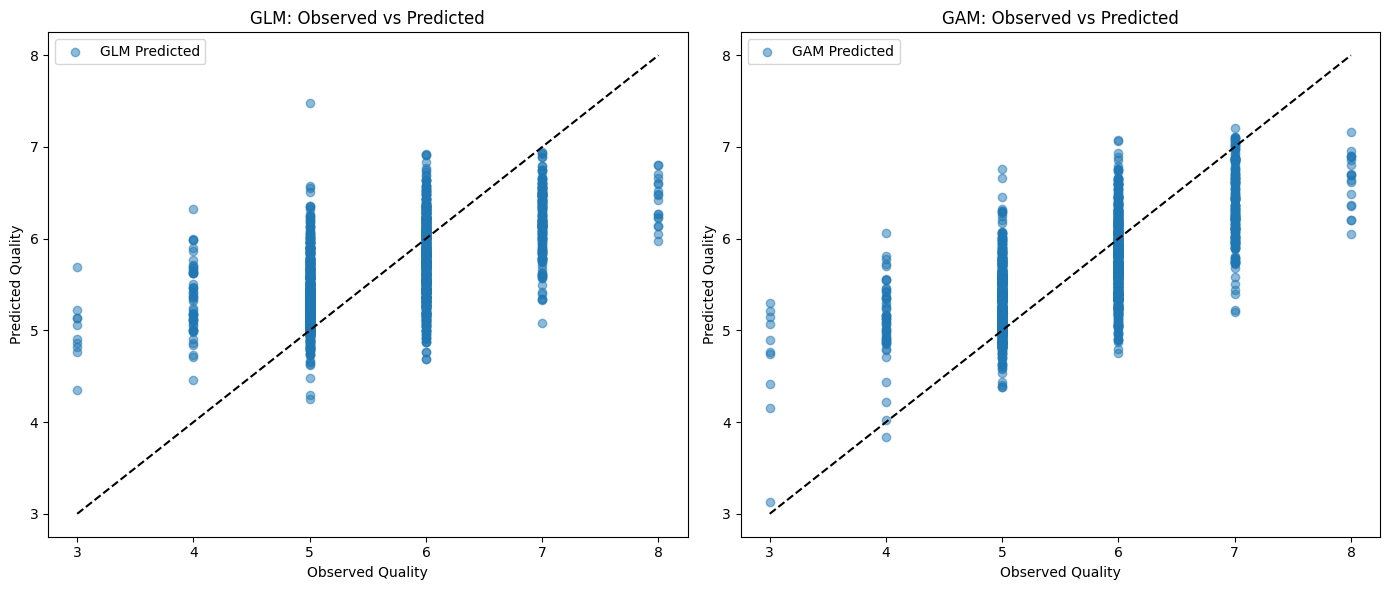

In [19]:
# Side-by-side Observed vs Predicted
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
axes[0].scatter(y, glm_preds, alpha=0.5, label='GLM Predicted')
axes[0].plot([y.min(), y.max()], [y.min(), y.max()], 'k--')
axes[0].set_title('GLM: Observed vs Predicted')
axes[0].set_xlabel('Observed Quality')
axes[0].set_ylabel('Predicted Quality')
axes[0].legend()

axes[1].scatter(y, gam_preds, alpha=0.5, label='GAM Predicted')
axes[1].plot([y.min(), y.max()], [y.min(), y.max()], 'k--')
axes[1].set_title('GAM: Observed vs Predicted')
axes[1].set_xlabel('Observed Quality')
axes[1].set_ylabel('Predicted Quality')
axes[1].legend()

plt.tight_layout()
plt.show()

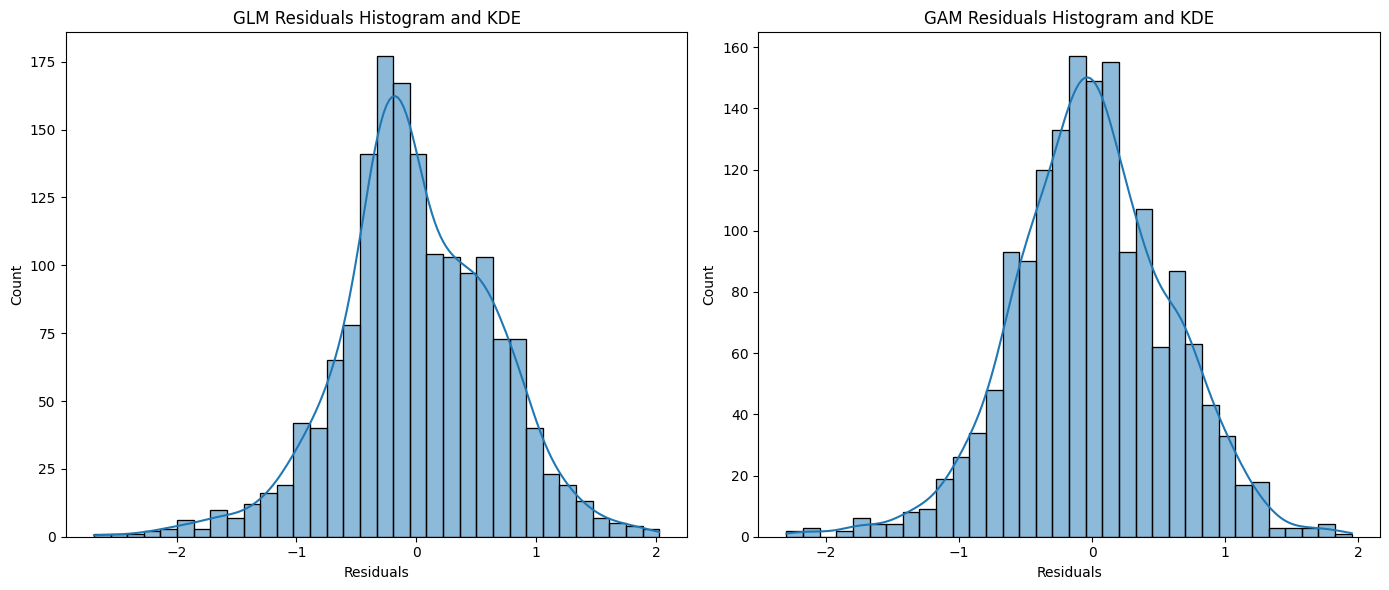

In [23]:
# Side-by-side Residual Histograms with KDE
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sns.histplot(glm_residuals, kde=True, ax=axes[0])
axes[0].set_title('GLM Residuals Histogram and KDE')
axes[0].set_xlabel('Residuals')

sns.histplot(gam_residuals, kde=True, ax=axes[1])
axes[1].set_title('GAM Residuals Histogram and KDE')
axes[1].set_xlabel('Residuals')

plt.tight_layout()
plt.show()

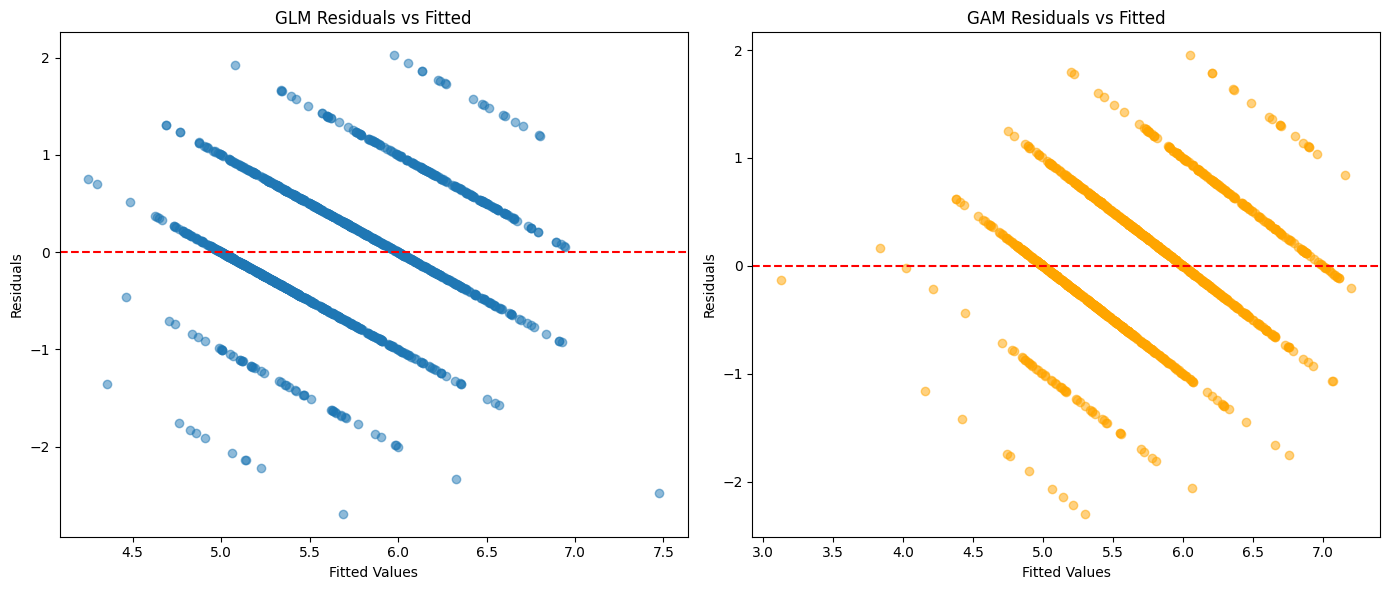

In [26]:
# Side-by-side Residuals vs Fitted Values (Homoscedasticity)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
axes[0].scatter(glm_preds, glm_residuals, alpha=0.5)
axes[0].axhline(0, color='red', linestyle='--')
axes[0].set_title('GLM Residuals vs Fitted')
axes[0].set_xlabel('Fitted Values')
axes[0].set_ylabel('Residuals')

axes[1].scatter(gam_preds, gam_residuals, alpha=0.5, color='orange')
axes[1].axhline(0, color='red', linestyle='--')
axes[1].set_title('GAM Residuals vs Fitted')
axes[1].set_xlabel('Fitted Values')
axes[1].set_ylabel('Residuals')

plt.tight_layout()
plt.show()

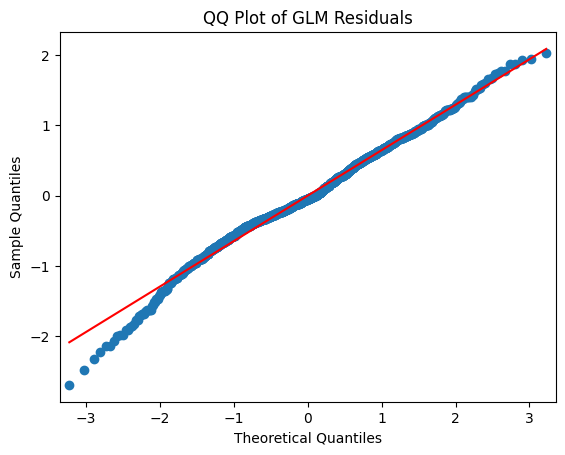

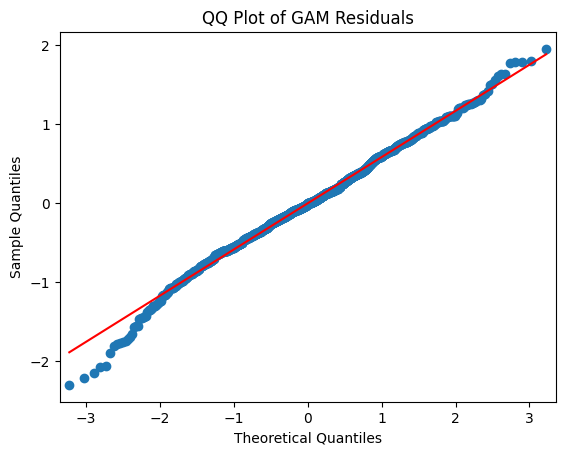

In [29]:
# QQ Plot for GLM Residuals
qqplot(glm_residuals, line='s')
plt.title('QQ Plot of GLM Residuals')
plt.show()

# QQ Plot for GAM Residuals
qqplot(gam_residuals, line='s')
plt.title('QQ Plot of GAM Residuals')
plt.show()

In [31]:
# Multicollinearity Check (VIF)
vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X_const.values, i+1) for i in range(len(X.columns))]
print(vif_data)

                 feature       VIF
0          fixed acidity  7.767512
1       volatile acidity  1.789390
2            citric acid  3.128022
3         residual sugar  1.702588
4              chlorides  1.481932
5    free sulfur dioxide  1.963019
6   total sulfur dioxide  2.186813
7                density  6.343760
8                     pH  3.329732
9              sulphates  1.429434
10               alcohol  3.031160


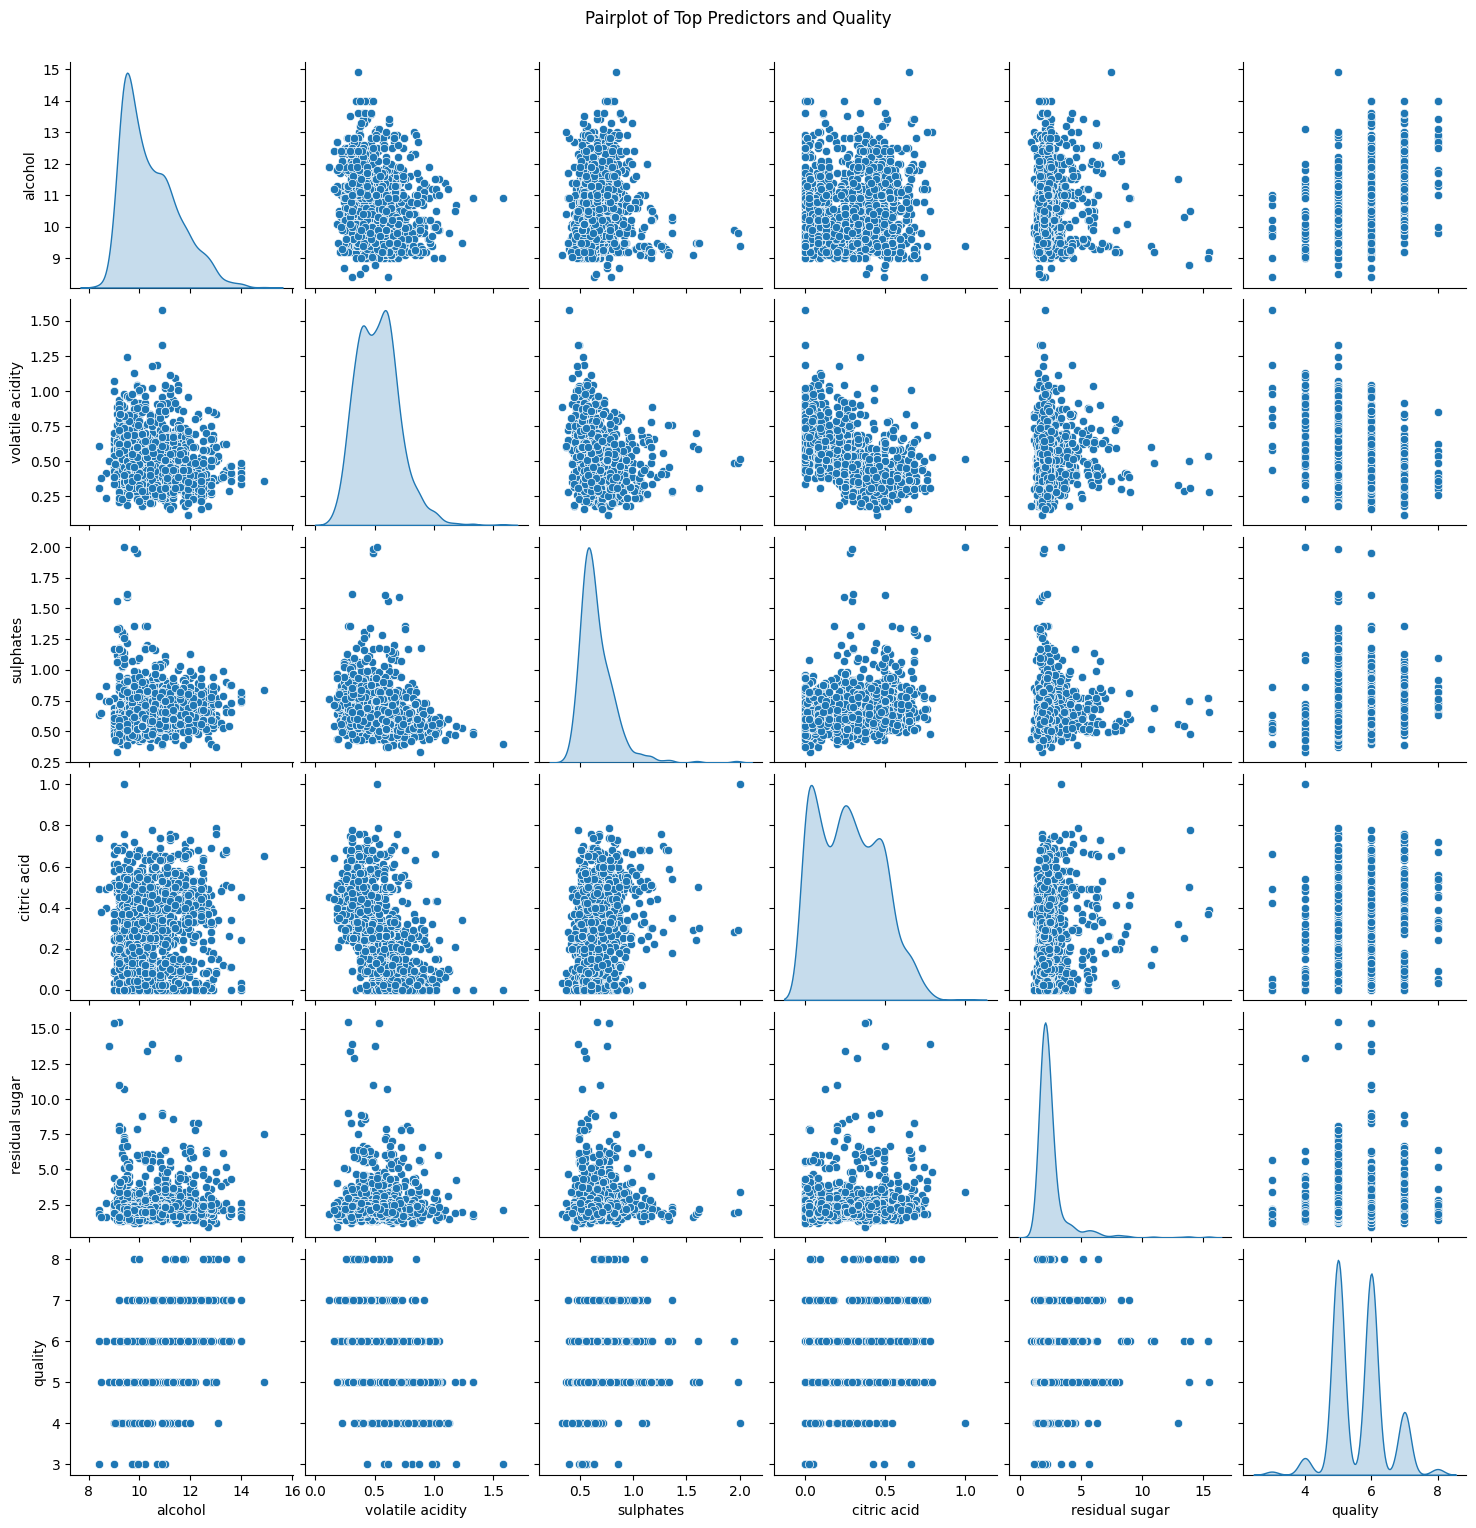

In [32]:
# ggplot-style Pairplot for select predictors
top_predictors = ['alcohol', 'volatile acidity', 'sulphates', 'citric acid', 'residual sugar']
sns.pairplot(df[top_predictors + ['quality']], diag_kind='kde')
plt.suptitle("Pairplot of Top Predictors and Quality", y=1.02)
plt.show()

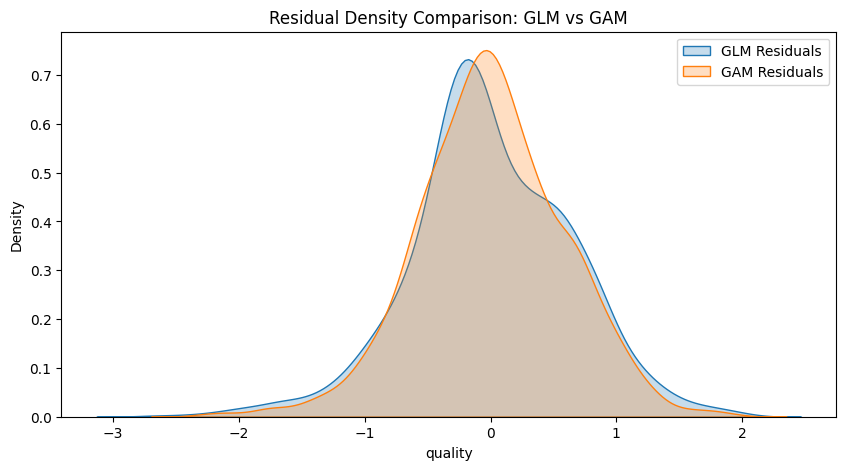

In [34]:
# Compare Residual Densities: GLM vs GAM
plt.figure(figsize=(10,5))
sns.kdeplot(glm_residuals, label='GLM Residuals', fill=True)
sns.kdeplot(gam_residuals, label='GAM Residuals', fill=True)
plt.title('Residual Density Comparison: GLM vs GAM')
plt.legend()
plt.show()

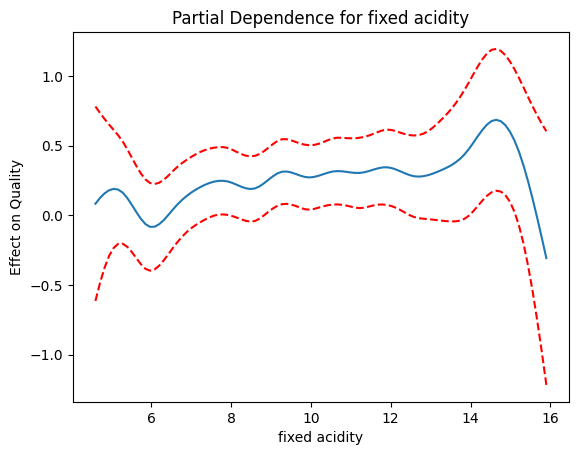

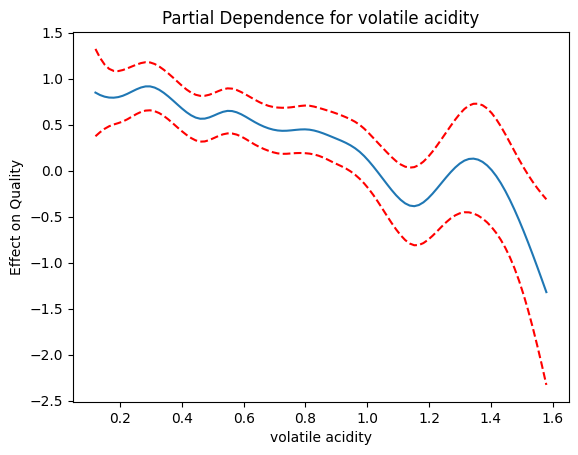

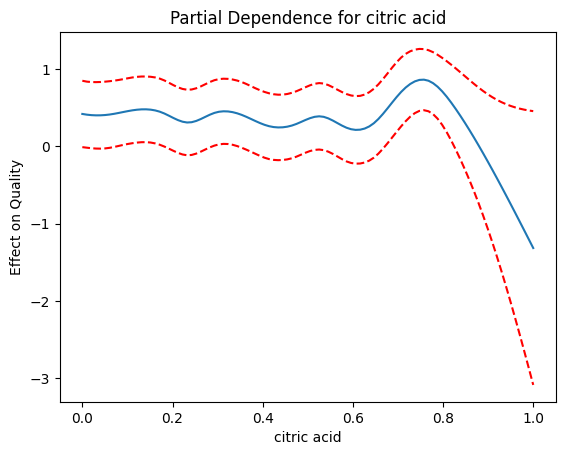

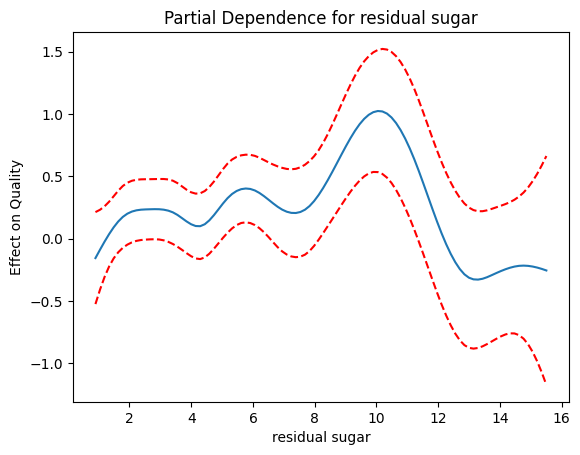

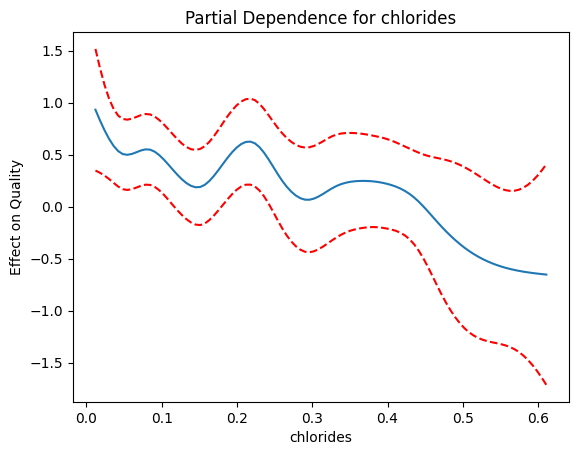

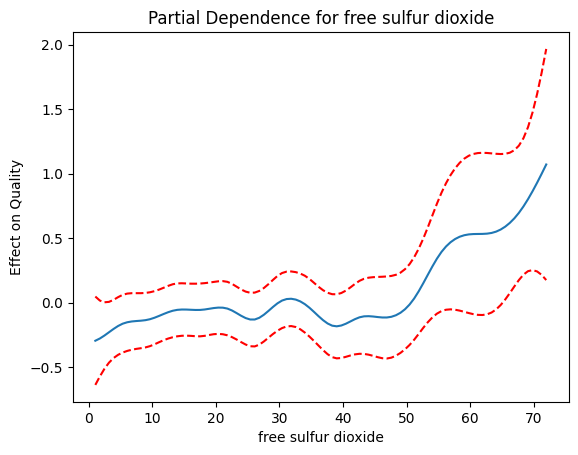

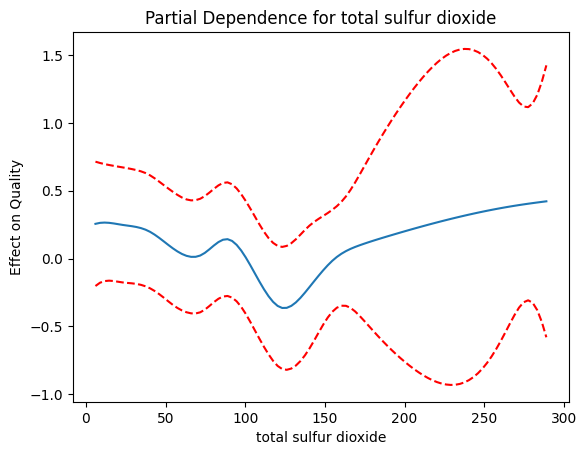

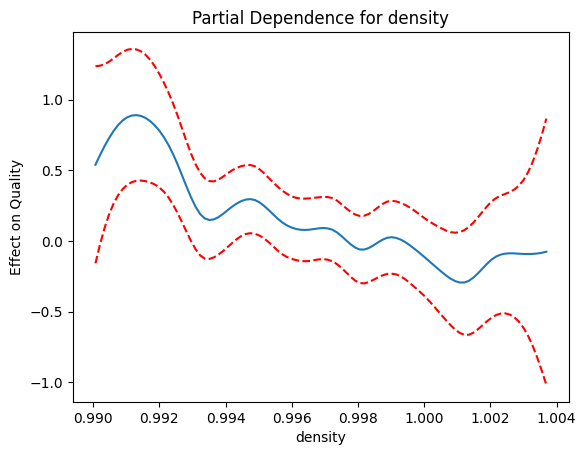

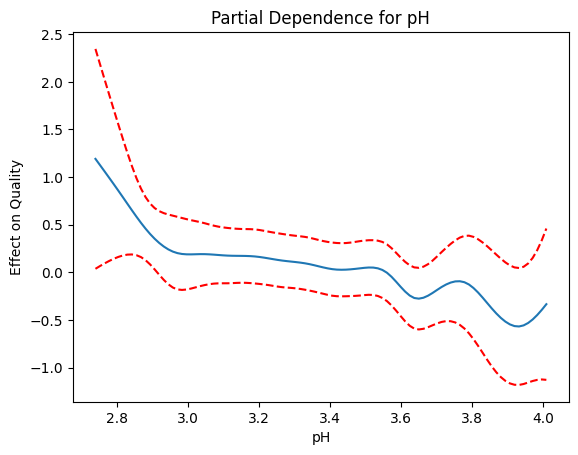

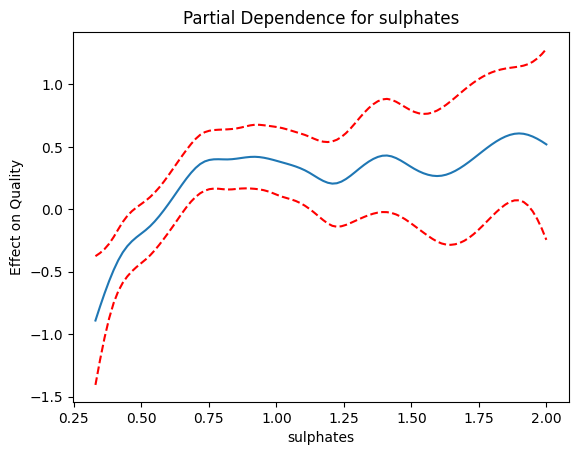

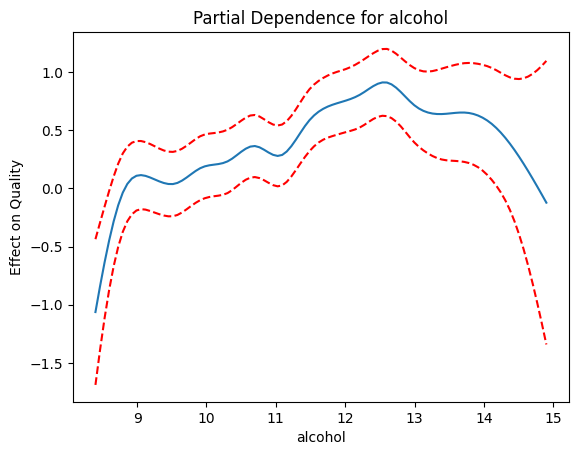

In [35]:
# Partial Dependence Plots for GAM
for i, feature in enumerate(X.columns):
    plt.figure()
    XX = gam.generate_X_grid(term=i)
    plt.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    plt.plot(XX[:, i], gam.partial_dependence(term=i, X=XX, width=0.95)[1], c='r', ls='--')
    plt.title(f'Partial Dependence for {feature}')
    plt.xlabel(feature)
    plt.ylabel('Effect on Quality')
    plt.show()